# Investigation of decease probability within half a year after heart failure incident

## The objective is to predict the mortality rate of patients 6 month after their heart failure event, given some general physiological and behavioural characteristics.

- The dataset is coming from US clinic and embed almost 300 patients having experienced a heart failure and 12 of their generic and biologic characteristics. The dataset also record their vital outcome up to 6 month after the event. The dependant variable we are trying to predict is the DEATH_STATUS that will take value 1 if the patient dies, 0 if he survive.


- We will make an Exploratory data Analysis (EDA) to uncover the first insight that data can tell us


- We will test various type of ML classifier and will compare their performace thanks to their ROC. 


- Enventually We will benchmark them with respect to a deep learning approach of the problem setting up 



# <font color='blue'>**Import package dependency**</font>

In [681]:
# to handle datasets
import pandas as pd
import numpy as np
import datetime as dt

# for plotting
import matplotlib.pyplot as plt

from scipy.stats import jarque_bera

import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to build the models
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve,f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals.six import StringIO
from xgboost import XGBClassifier

# to evaluate the models
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve,f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# <font color='blue'>**Import data set and drop un-necessary variables**</font>

In [100]:
# load dataset
data = pd.read_csv('C:/Users/amaur/OneDrive/Documents/Data science/Decease of hart fail prediction/Data/heart_failure_mortality.csv', sep =';')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

data.drop(['Unnamed: 0', 'time'], axis=1, inplace=True)

(299, 14)


In [6]:
# Save the dataset
data.to_csv('C:/Users/amaur/OneDrive/Documents/Data science/Decease of hart fail prediction/deploy_heart_failure_model/heart_failure_mortality.csv', sep=';')

In [101]:
# Check at remaining variables and their names
data.columns

Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'DEATH_EVENT', 'Smoker', 'anaemic',
       'high_blood_pression', 'diabetic', 'gender'],
      dtype='object')

# <font color='blue'>**Exploratory Data Analysis**</font>

## <font color ='green'> **Check numerical variables**</font>

### - <font color='black'> **Identification**</font>

In [102]:
num_vars = [var for var in data.columns if data[var].dtypes !='O']
print('Number of numerical variables: ', len(num_vars))
num_vars.remove('DEATH_EVENT')
data[num_vars].head()

Number of numerical variables:  7


,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
0,75.0,582,20,265000.00,1.9,130
1,55.0,7861,38,263358.03,1.1,136
2,65.0,146,20,162000.00,1.3,129
3,50.0,111,20,210000.00,1.9,137
4,65.0,160,20,327000.00,2.7,116


### - Check their distribution

In [673]:
def analyse_continuous(df, var):
    ''' The function will plot the histogram for the variable'''
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of occurence')
    plt.xlabel(var)
    plt.title(var)
    plt.show()

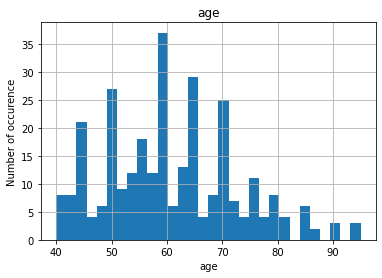

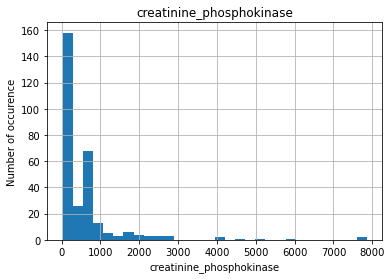

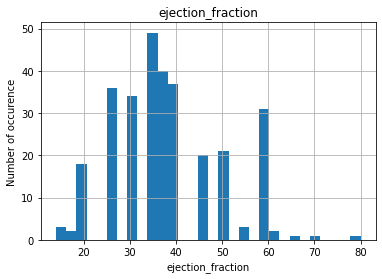

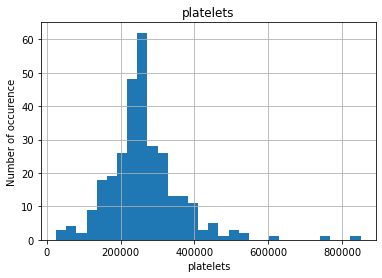

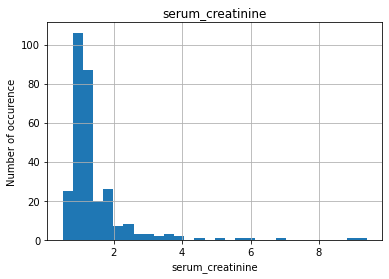

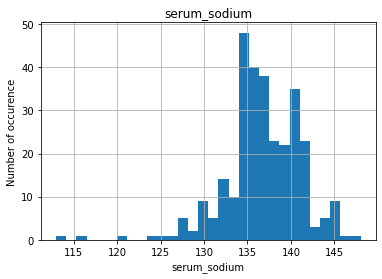

In [674]:
for var in num_vars:
    analyse_continuous(data, var)

<font color='red'>**Interpretation**</font>

Variables are rather skewed a good although generalized linear models can handle a fair degree of non normality in the regressors without bais on the models, some easy transformation like a logarithm transformation.

### - Log transforming the continuous variables

In [672]:
def analyse_transformed_continuous(df, var):
    ''' Function that will pass the data to logarithm if they are strictly 
    positive (as a log domain of definition excludes negative values)
     eventually the function plug an histogram of the var distribution'''
    df = df.copy()

    # log does not take 0 or negative values, so let's be
    # careful and skip those variables
    if any(data[var] <= 0):
        pass
    else:
        # log transform the variable
        df[var] = np.log(df[var])
        df[var].hist(bins=30)
        plt.ylabel('Number of occurence')
        plt.xlabel(var)
        plt.title(var)
        plt.show()

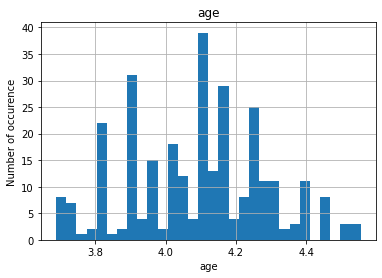

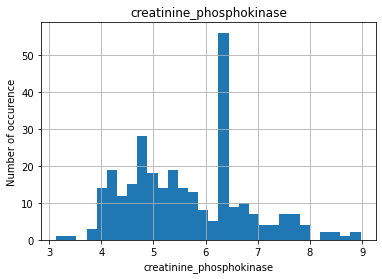

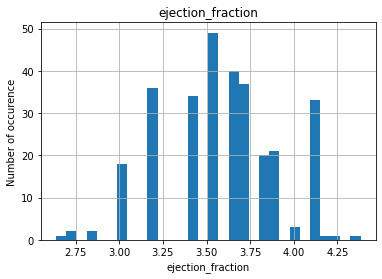

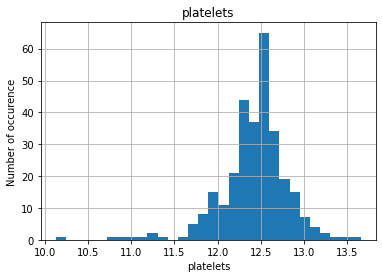

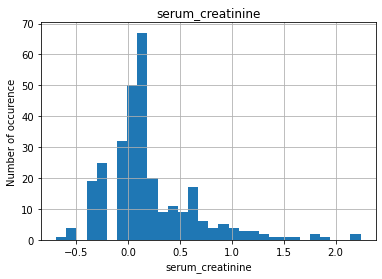

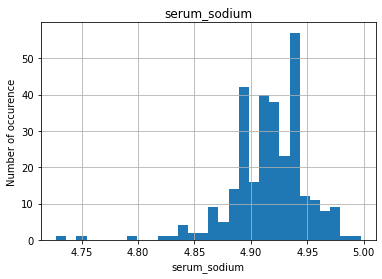

In [106]:
for var in num_vars:
    analyse_transformed_continuous(data, var)

<font color='red'>**Interpretation**</font>

We observe a increasing in the normality of the data although the problem is not fully solved as we still see somme skewed distribution or bimodal distribution (creatinine_phosphokinase). However the situation as fairly improved.

### - Check the distribution of the continuous variable differentiating with respect to the outcome status - Death or survival

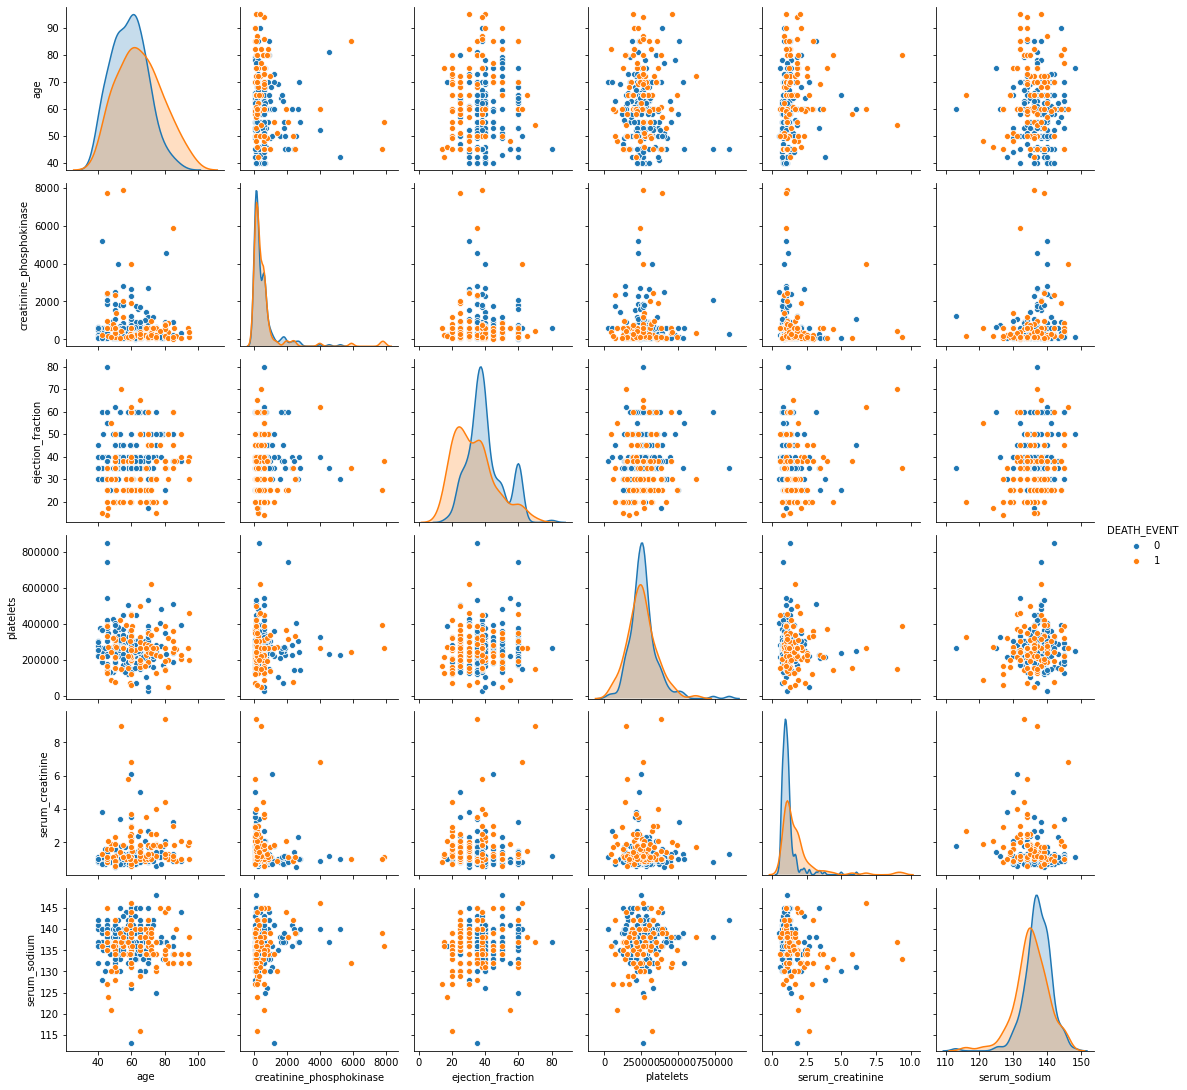

In [107]:
sns.pairplot(data[num_vars + ['DEATH_EVENT']], hue='DEATH_EVENT')

<font color='red'>**Interpretation**</font>

- We can check that the distribution are different given the survival rate for the following variables:


    - Age: The survival rate is higer for younger patient than for older, one can think of age as a variable we will have to add to the model.
    
    - Ejection fraction: the distribution function of the non-survivor is higher for low ejection fraction. The mode for the           survivor is at higher values of ejection fractions than for the dead. We see an "outlier" in the distribution in the             second mode at really high values of ejection fraction.
    
    - Serum creatinine: The mode for the two outcomes is situated at the same value for the two outcomes. However, it is               more skewed to higher values for the non-survivors individuals
    
    - Serum Sodium: The mode for the two outcomes is situated at the same value for the two outcomes. However, it is                   more skewed to higher values for the survivors individuals
    
    
- However, creatinine phosphokinase and platelets have kind of highly similar distribution functions.


- When having a first look at the graphics we can see no strong evident correlation structure between variables, wether the outcome considered for this correlation is surviror or non-survivor.

### - Let's now check for outlier

In [675]:
def find_outliers(df, var):
    df = df.copy()
    ''' The function log-transform the data and plot the box plot of the variable'''

    # log does not take negative values, so let's be
    # careful and skip those variables
    if any(data[var] <= 0):
        pass
    else:
        df[var] = np.log(df[var])
        df.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()

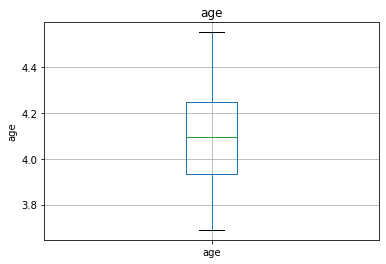

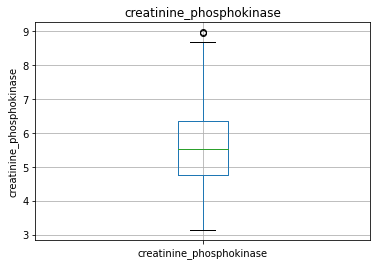

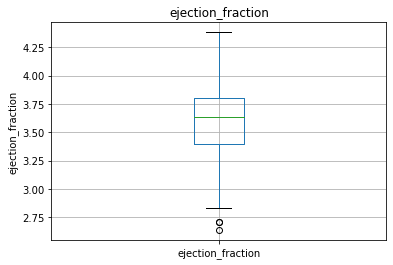

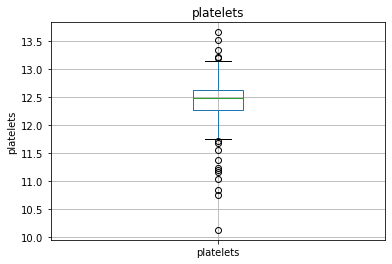

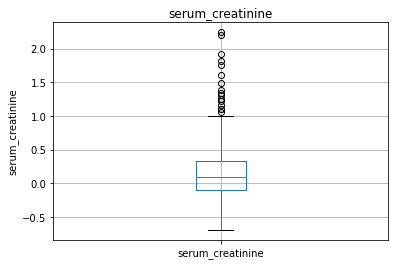

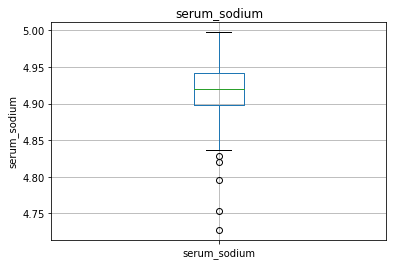

In [109]:
for var in num_vars:
    find_outliers(data, var)

<font color='red'>**Interpretation**</font>

There are some outliers, we will trim them and check statistically if the independant variables are normally distributed (although we shall still recall that GLM can tolerate a certain amount of non linearity)

In [676]:
def trimming_outlier_distribution(df, var, max_quant, min_quant):
    ''' The function allows to define an interquantile distribution above
     and under which you want to discard the observation and eventually
     plots the boxplot for the variable'''
    #df= df.copy()
    
    Qmin = df[var].quantile(min_quant)
    Qmax = df[var].quantile(max_quant)
    IQR = Qmax - Qmin

    df = df[~((df[var] > (Qmax + 1.5 * IQR)))]
    
    if any(data[var] <= 0):
        pass
    else:
        df[var] = np.log(df[var])
        df.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()

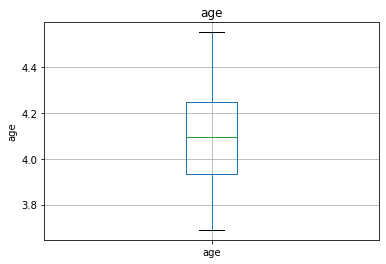

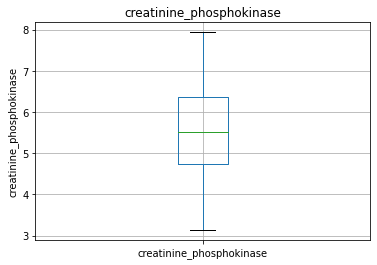

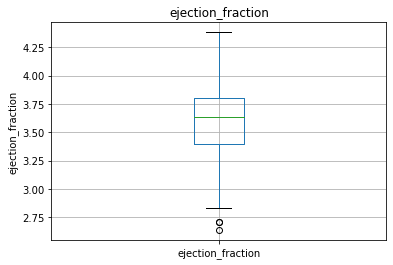

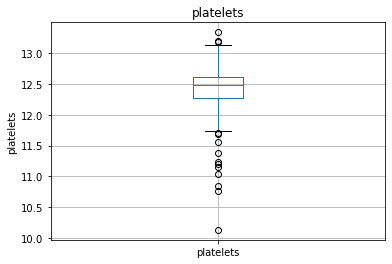

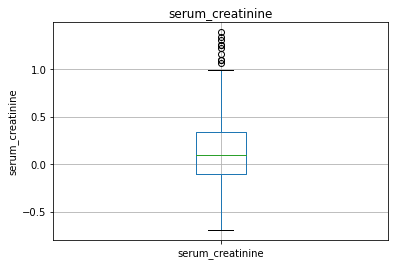

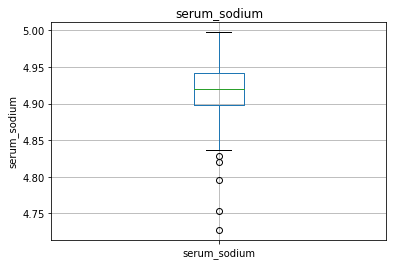

In [111]:
for var in num_vars:
    trimming_outlier_distribution(data, var, 0.90, 0.10)

In [677]:
def trimming_data(df, max_quant, min_quant):
    ''' The function trim the data and returns a trimmed dataset'''
    Qmin = df[num_vars].quantile(min_quant)
    Qmax = df[num_vars].quantile(max_quant)
    IQR = Qmax - Qmin
    
    df = df[~((df < (Qmin - 1.5 * IQR)) |(df > (Qmax + 1.5 * IQR))).any(axis=1)]
    return df

#### Create a new dataset with trimmed data

In [113]:
data_clean = trimming_data(data, 0.80, 0.20)

In [114]:
print(len(data_clean))
data_clean.head(2)

246


,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT,Smoker,anaemic,high_blood_pression,diabetic,gender
0,75.0,582,20,265000.0,1.9,130,1,non smoker,no,yes,no,male
2,65.0,146,20,162000.0,1.3,129,1,smoker,no,no,no,male


<font color='red'>**Interpretation**</font>

The dataset has lost around 60 observations.

#### Check at the distribution for the trimmed data set

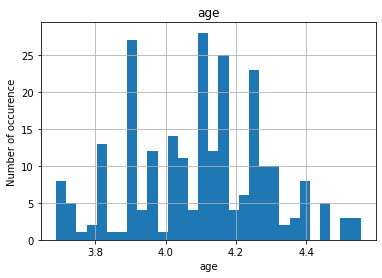

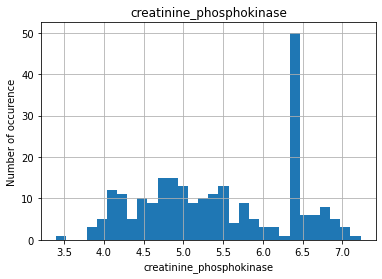

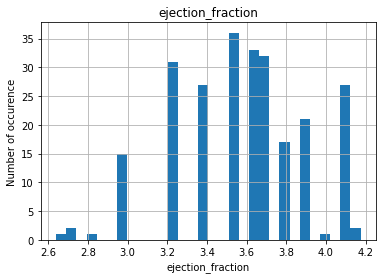

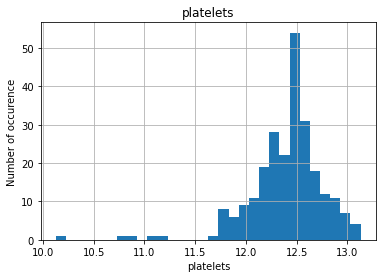

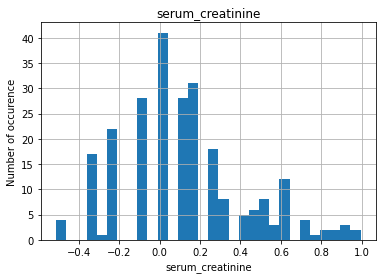

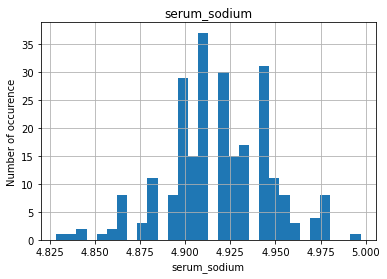

In [115]:
for var in num_vars:
    analyse_transformed_continuous(data_clean, var)

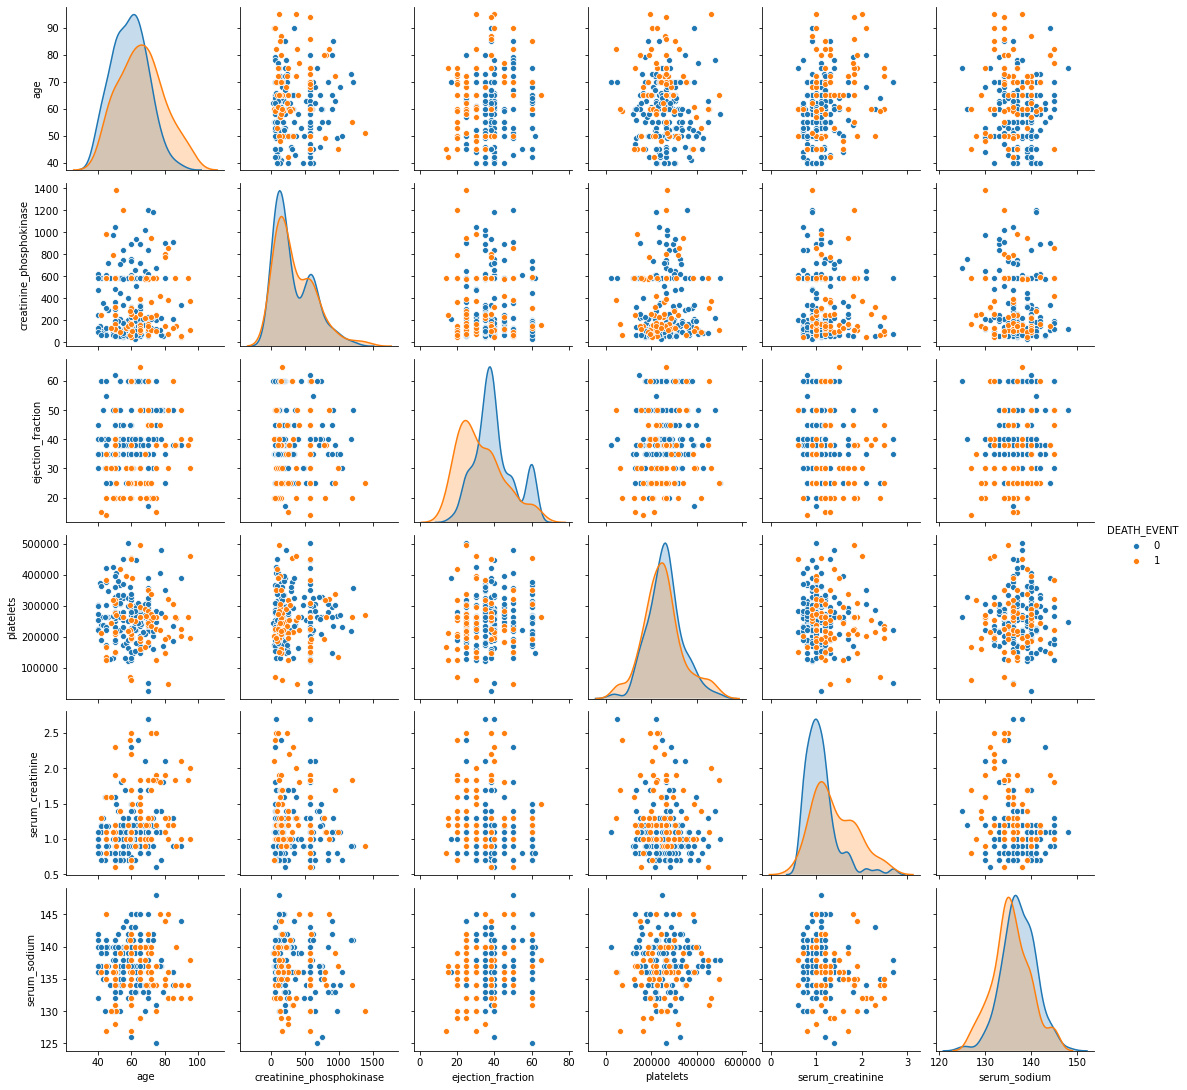

In [116]:
sns.pairplot(data_clean[num_vars + ['DEATH_EVENT']], hue='DEATH_EVENT')

<font color='red'>**Interpretation**</font>

Trimming the dataset for outliers has not drastically change the level shape of the distribution function of the various data according to the outcome. This means that trimming outliers would not drive a major change in the predictive power of the various variables.

### Let's check formally for normality thanks to Jarques Bera Test

In [678]:
def normal_dist_testing (df, var):
    '''Compute the Jarques Bera Test'''
    df= df.copy()
    #set up a df to strore results of the JB test
    jarq_df=pd.DataFrame(columns=["variable","test statistic","p_value"])
    
    jarq =jarque_bera(df[var])
    jarq_df=jarq_df.append({"variable":var,
                   "test statistic":jarq[0],
                   "p_value":jarq[1]}, ignore_index=True)
    display(jarq_df)

In [118]:
for var in num_vars:
    normal_dist_testing(data_clean, var)

,variable,test statistic,p_value
0,age,6.284483,0.043186


,variable,test statistic,p_value
0,creatinine_phosphokinase,49.502821,1.780731e-11


,variable,test statistic,p_value
0,ejection_fraction,7.83145,0.019926


,variable,test statistic,p_value
0,platelets,9.915855,0.007027


,variable,test statistic,p_value
0,serum_creatinine,111.387964,0.0


,variable,test statistic,p_value
0,serum_sodium,1.38062,0.501421


<font color='red'>**Interpretation**</font>

The null hypothesis being normality so accepting it (p_value>0.05) means that the distribution is Gaussian.

Triming the observation we achieve normality for the sodium concentration, and the age, we are close to it for ejection fraction, we will tolerate the rest because we do not want to exclude too much data from the analysis.

## <font color ='green'> **Check numerical variables**</font>

### - <font color='black'> **Identification**</font>

In [119]:
cat_vars = [var for var in data.columns if data[var].dtypes == 'O']
data[cat_vars].head()

,Smoker,anaemic,high_blood_pression,diabetic,gender
0,non smoker,no,yes,no,male
1,non smoker,no,no,no,male
2,smoker,no,no,no,male
3,non smoker,yes,no,no,male
4,non smoker,yes,no,yes,female


### - Let's analyse their distribution according to the outcome, death or not survival

In [679]:
def analyse_discrete(df, var):
    ''' Computes the proportion of death vs survival according to binary variables'''
    df = df.copy()
    df.groupby(var)['DEATH_EVENT'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('Mean Death event')
    plt.show()

In [121]:
def analyse_discrete_gender(df, var):
    df = df.copy()
    df.groupby(var)['gender'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('occurence male_female')
    plt.show()

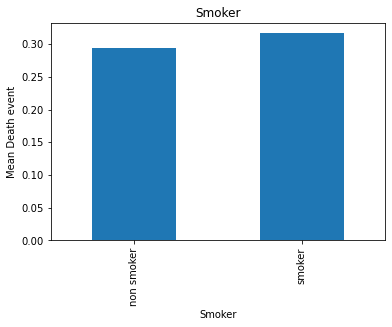

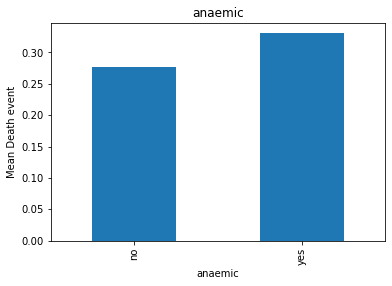

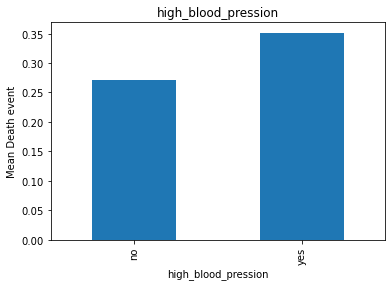

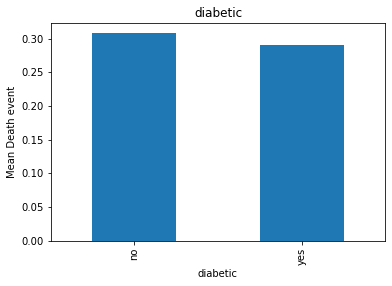

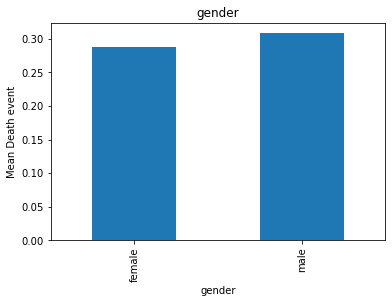

In [122]:
for var in cat_vars:
    analyse_discrete(data_clean, var)

<font color='red'>**Interpretation**</font>

- The data are rather well balanced between the dummy variables, the proportion of deceased is equal if:
    - the patient is diabetic
    - the patient is smoking
    
    
- The rate mortality is however a bit higher if 
    - the patient has high blood pressure (It is where the highest desiquilibrium is observed)
    - the patient has anemia
    - The mortality seems to be a bit higher if the patient is male

### - Encode variables for a suitable estimation phase

In [124]:
cleanup_types = {"Smoker": {"non smoker": 0, "smoker": 1},"anaemic": {"yes": 1, "no": 0},
               "high_blood_pression": {"yes": 1, "no": 0}, "diabetic": {"yes": 1, "no": 0},
               "gender": {"male": 1, "female": 0}}
def encode_dep(df):
    df.replace(cleanup_types, inplace=True)
    return df

In [126]:
encode_dep(data_clean)

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT,Smoker,anaemic,high_blood_pression,diabetic,gender
0,75.0,582,20,265000.0,1.9,130,1,0,0,1,0,1
2,65.0,146,20,162000.0,1.3,129,1,1,0,0,0,1
3,50.0,111,20,210000.0,1.9,137,1,0,1,0,0,1
5,90.0,47,40,204000.0,2.1,132,1,1,1,1,0,1
6,75.0,246,15,127000.0,1.2,137,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
291,60.0,320,35,133000.0,1.4,139,0,0,0,0,0,1
292,52.0,190,38,382000.0,1.0,140,0,1,0,0,1,1
293,63.0,103,35,179000.0,0.9,136,0,1,1,0,1,1
294,62.0,61,38,155000.0,1.1,143,0,1,0,1,1,1


<font color='black'> **It is supposed to be notorious knowledge that males have worst living hygene than women, so let us check that, as being a male could absorb the effect of variable such as smoking as an example** </font>

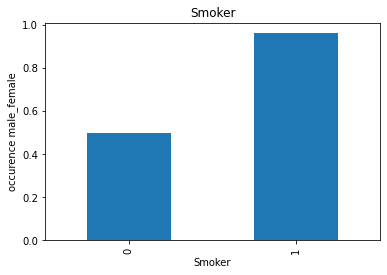

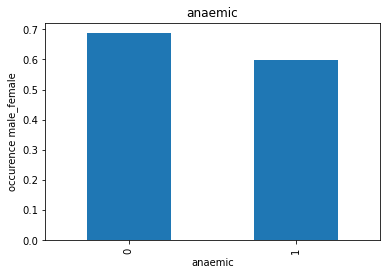

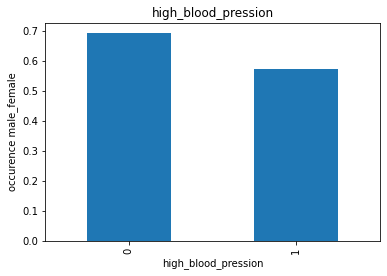

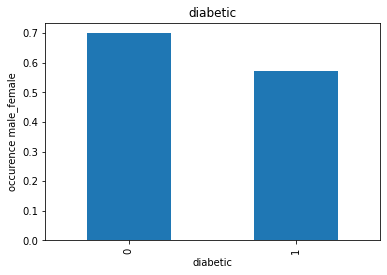

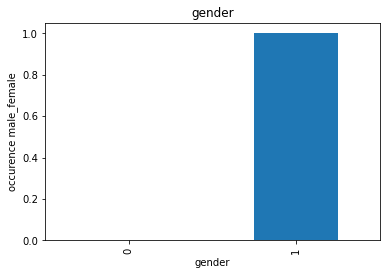

In [127]:
for var in cat_vars:
    analyse_discrete_gender(data_clean, var)

<font color='red'>**Interpretation**</font>

Within the trimmed data there is much more male in the smoker population than female. For the other co-deases variable it seems to be the opposite, the female are a bit more present.

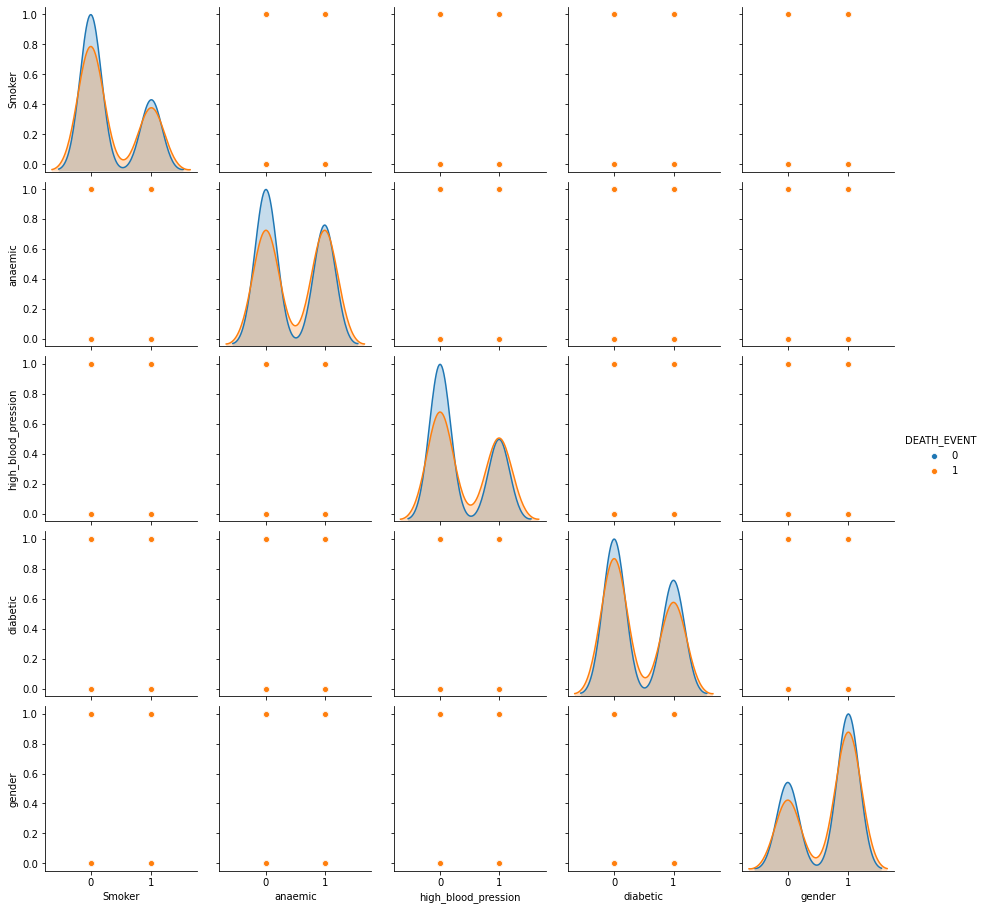

In [128]:
sns.pairplot(data_clean[cat_vars + ['DEATH_EVENT']], hue='DEATH_EVENT')

<font color='red'>**Interpretation**</font>

Being non smoker and not being anaemic and not showing high blood pression seems to be discriminant in the process of surviving, but does not seems to be discriminant in explaining the non-survival outcome, where the proportion seems to be identical. For the other variables (Gender, diabetes, do not seems to be determinant)

### - Check at the proportion of survivors and non survivors to check the balance of the sample

In [129]:
# Count target values
target_count = data_clean['DEATH_EVENT'].value_counts()

# # print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print('Percentage of Majority Class: {:f}'.format(
    round(target_count[0] / sum(target_count), 4) * 100))

Class 0: 172
Class 1: 74
Proportion: 2.32 : 1
Percentage of Majority Class: 69.920000


<font color='red'>**Interpretation**</font>

The sample is not strongly unbalanced, so we should not have an urgent need to generate class 1 data by SWORE algorith as an example, we will use the data as is...

## <font color ='green'> **EDA Wrap Up**</font>

- The dataset is balanced enough in the dependant data set not to have to rely on an augmentation algorithm.


- We have discarding around 50 data corresponding to the data 20 percent higher and lower than the value of the first and third quantile.


- We have a set of binary data that are well balanced between the death and survival outcome except for the blood pressure, smoking and the gender. However the proportion of smoker is highly more represented within the male population and hence the fact that there is more dying male than female can be blurred with the fact that more men are smokers.


- We have distribution that are often close to normal distribution within the continuous regressors, with distribution that fairly overlap between the two outcome status. However we could identify some different distribution between the outcome that we can think will be important variables to explain the death or survival status.
    - Age
    - Serum Creatinine
    - Ejection fraction 

# <font color ='blue'> **ML models fitting and comparisons**</font>

## <font color ='green'> **Separate train ans test set and prepare them for estimation**</font>

### - Separate train and test sets

In [259]:
X_train, X_test, y_train, y_test = train_test_split(
    data_clean,
    data_clean['DEATH_EVENT'],
    test_size=0.35,
    # we are setting the seed here
    random_state=0,
    stratify = data_clean['DEATH_EVENT'])

X_train.shape, X_test.shape

((159, 12), (87, 12))

In [260]:
X_train.drop(['DEATH_EVENT'], axis=1, inplace=True)
X_test.drop(['DEATH_EVENT'], axis=1, inplace=True)

### - Set up a scaler and generate an alternative dataset where data are scaled
(As some algorithms will need to run on scaled data while other will perform better when non scaled, it is more friendly to have thoses two type of dataset in our hands)

In [261]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[num_vars])

# transform the train and test set
X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_vars]), columns = num_vars)

X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_vars]), columns = num_vars)

#### Adding dichotomous var to the scaled dataset, as they were excluded from the scaling and therefor from the newly created scaled dataset

In [262]:
# Smokers
X_train_scaled['Smoker'] = X_train['Smoker'].values
X_test_scaled['Smoker'] = X_test['Smoker'].values

#Anaemic
X_train_scaled['anaemic'] = X_train['anaemic'].values
X_test_scaled['anaemic'] = X_test['anaemic'].values

# High blood pression
X_train_scaled['high_blood_pression'] = X_train['high_blood_pression'].values
X_test_scaled['high_blood_pression'] = X_test['high_blood_pression'].values

# Diabetic
X_train_scaled['diabetic'] = X_train['diabetic'].values
X_test_scaled['diabetic'] = X_test['diabetic'].values

# Gender
X_train_scaled['gender'] = X_train['gender'].values
X_test_scaled['gender'] = X_test['gender'].values

### - Reseting indexes for newly splitted datasets
(as randomly splitting the training and tests set will create a non ordered set of index that will cause algorithms to fail in fitting the models)

In [263]:
X_train = X_train.reset_index()
X_train.drop(['index'], axis=1, inplace=True)

X_test = X_test.reset_index()
X_test.drop(['index'], axis=1, inplace=True)

y_train = y_train.reset_index()
y_train.drop(['index'], axis=1, inplace=True)

y_test = y_test.reset_index()
y_test.drop(['index'], axis=1, inplace=True)

### - Generating variable to capture cross variables effects
(We have seen that <font color='red'>**high blood pressure** </font> is the most unbalanced variable between the death and survival outcome, we will test the cross variable effect with respect to this one)

In [254]:
## Regressor with cross effect taken into account

##Generating cross variables in training set
X_train['high_blood * smoker'] = X_train['Smoker']*X_train['high_blood_pression']
X_train['high_blood * anaemic'] = X_train['anaemic']*X_train['high_blood_pression']
X_train['high_blood * diabetic'] = X_train['diabetic']*X_train['high_blood_pression']
X_train['Smoker * diabetic'] = X_train['Smoker']*X_train['diabetic']

##Generating cross variables in scaled training set
X_train_scaled['high_blood * smoker'] = X_train_scaled['Smoker']*X_train_scaled['high_blood_pression']
X_train_scaled['high_blood * anaemic'] = X_train_scaled['anaemic']*X_train_scaled['high_blood_pression']
X_train_scaled['high_blood * diabetic'] = X_train_scaled['diabetic']*X_train_scaled['high_blood_pression']
X_train_scaled['Smoker * diabetic'] = X_train_scaled['Smoker']*X_train_scaled['diabetic']

##Generating cross variables in scaled test set
X_test_scaled['high_blood * smoker'] = X_test_scaled['Smoker']*X_test_scaled['high_blood_pression']
X_test_scaled['high_blood * anaemic'] = X_test_scaled['anaemic']*X_test_scaled['high_blood_pression']
X_test_scaled['high_blood * diabetic'] = X_test_scaled['diabetic']*X_test_scaled['high_blood_pression']

## <font color ='green'> **Train a logistic regression model as a baseline model**</font>
(Here we also aim to identify and quantify the KSF explaining the death or survival status, we will use statsmodel that is more conviening for that matter latter on (prediction phases) we will rather use sci-kit learn)

### - define a subset of regressors to isolate single variable effects 

In [265]:
## Naive model
regressors_simple = ['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'Smoker',
 'anaemic',
 'high_blood_pression',
 'diabetic',
 'gender']

### - Checking the significance and force of various regressors without cross variable effects

In [257]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train, X_train_scaled[regressors_simple])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.499627
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.184     
Dependent Variable:    DEATH_EVENT        AIC:                180.8812  
Date:                  2020-11-26 13:00   BIC:                214.6392  
No. Observations:      159                Log-Likelihood:     -79.441   
Df Model:              10                 LL-Null:            -97.380   
Df Residuals:          148                LLR p-value:        8.8293e-05
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        6.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
age                       0.5388   0.2111  2.5527 0

In [256]:
logit_model=sm.Logit(y_train, X_train_scaled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.482513
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.212     
Dependent Variable:    DEATH_EVENT        AIC:                183.4391  
Date:                  2020-11-26 12:58   BIC:                229.4727  
No. Observations:      159                Log-Likelihood:     -76.720   
Df Model:              14                 LL-Null:            -97.380   
Df Residuals:          144                LLR p-value:        0.00015830
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        6.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
age                       0.4895   0.2178  2.2477 0

#### <font color ='red'> **Interpretation**</font>

- We see that adding cross variable to the model has increased the model efficiency in term global precision in the training phase. Although most of the cross variables are insignificant and add complexity to the model we will therefore leave them into the model. Moreover, it allows to <font color ='black'>**depollute the effect of some variables**</font> such as diabetes that become a significant explanator of the death status (but weirdly being diabetic does seem to favor survival)


- When the age increase of 1% the the death probability will increase of 48% 


- A high ejection fraction (1% increase) will reduce strongly the death probability (57%)


- Males seems to have lower risk of death than women, we also have seen that women in the data set were more prompt to have high blood pression or anaemia than male. <font color ='red'> **Important warning**</font> : it seems counter intuitive as women in the population seems to have better hygene than men. There is however here a selection bias as we consider only a sick population here, so it we might consider only a subset of the population with bad hygene in the baseline.



## <font color ='green'> **Test a logistic regression model as a baseline model**</font>

### <font color ='red'> In prediction, we will try to minimise the False Negatives (The real outcome is death and the models predict survival) and maximize the True positive which is predicting the most accuratly the death status.</font>


### <font color ='red'>Indeed in this context, predictiong survival when the outcome will be dead is a dramatic mistake, whereas predicting death when the actual outcome is survival will only end up in a wonderfull and happy surprise. In other word we are interested more at the RECALL CURVE or the bottom left of the ROC CURVE</font>

### - We are now using Sci-kit Learn, our goal is now to predict and not to identify the KSF explaining the death or survival status

In [272]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
log_reg = LogisticRegression(penalty = 'l2')
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [276]:
y_pred = log_reg.predict(X_test_scaled)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(log_reg.score(X_test_scaled, y_test)))

Accuracy of logistic regression classifier on test set: 0.77


### - evaluation of the model

In [278]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[52  9]
 [11 15]]


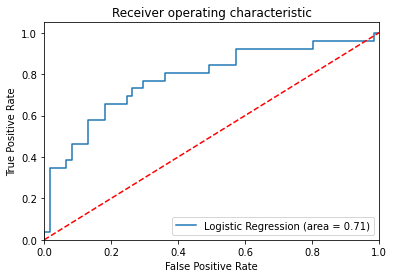

In [279]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test_scaled))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<font color ='red'> **Interpretation**</font>

The confusion Matrix and the ROC Curve shows us that we do a fairly good job at predicting the survival status but we fail predicting correctly the death rate.

Indeed we can see here that on 26 death status (11 + 15), we get wrong 42% of the time  (11/(11 + 15)), so that might not be the best outcome that we could imagine and not good enough to be used in real life application 

### - Plotting the recall curve for various thresholds
(The threshold is the probability above which we will consider an outcome to be 1 rather than 0)

In [280]:
# Calculate ROC curve for logistic regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(
    y_test,
    log_reg.predict_proba(X_test_scaled)[:, 1])

# Calculate area under the curve (AUC) for ROC
auc_lr = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])

In [69]:
def fbeta(model, y_test=y_test, X_test=X_test[regressors]):
    """
    Calculate the probability threshold that yields the highest f_beta value
    input: fitted model, y_test, X_test
    """
    prob_thresholds = np.arange(0, 1, 0.005)
    fbeta = []
    for prob in prob_thresholds:
        fbeta.append(
            fbeta_score(y_test,
                        model.predict_proba(X_test_scaled)[:, 1] > prob, 3))
    all_fbeta = list(zip(prob_thresholds, fbeta))
    best_fbeta = max(list(zip(prob_thresholds, fbeta)), key=lambda x: x[1])
    print(
        'Probability that yields the best fbeta score is {} with fbeta={:5f}'.
        format(best_fbeta[0], best_fbeta[1]))
    return all_fbeta, best_fbeta

In [281]:
# Calculate fbeta for logistic regression
all_fbeta_lr, best_fbeta_lr = fbeta(log_reg, X_test=X_test_scaled)
p_thresh = best_fbeta_lr[0]

Probability that yields the best fbeta score is 0.155 with fbeta=0.819113


## <font color='green'> Classifiers comparison </font>
- (We will compare the logistic regression with majors ML other classifers, XGBoost, KNN)
- For each classifer we will compute the True Positive Rate and False Positive Rate in order to compute the ROC curve. We will also display the confusion matrix which is quite usefull to visualise straightforwardly the death predicting power.

### - Decision tree

In [283]:
lr_coefs = list(zip(X_train_scaled, log_reg.coef_[0]))
lr_coefs_df = pd.DataFrame(lr_coefs)
lr_top_coefs = [x for x in lr_coefs if np.abs(x[1]) > .07]
lr_top_coefs = sorted(lr_top_coefs, key=(lambda x: x[1]), reverse=True)
lr_top_coefs_df = pd.DataFrame(lr_top_coefs)

In [286]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

# Calculate fbeta for decision tree
all_fbeta_dt, best_fbeta_dt = fbeta(dt,
                                    X_test=X_test)  # not scaled data for dt

# Calculate ROC Score and AUC for decision tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(
    y_test,
    dt.predict_proba(X_test)[:, 1])  # not scaled data for dt
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

Probability that yields the best fbeta score is 0.0 with fbeta=0.524590


### - KNN

In [298]:
# Instantiate Model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit Model
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [299]:
# Calculate fbeta for KNN
all_fbeta_knn, best_fbeta_knn = fbeta(knn,
                                      X_test=X_test_scaled)  # scaled for knn

# Calculate ROC Score and AUC for knn
fpr_knn, tpr_knn, thresholds_knn = roc_curve(
    y_test,
    knn.predict_proba(X_test_scaled)[:, 1])  # scaled for knn
auc_knn = roc_auc_score(
    y_test,
    knn.predict_proba(X_test_scaled)[:, 1])  # scaled for knn

Probability that yields the best fbeta score is 0.0 with fbeta=0.748299


In [300]:
y_pred_knn = knn.predict(X_test_scaled)
confusion_matrix = confusion_matrix(y_test, y_pred_knn)
print(confusion_matrix)

[[54  7]
 [16 10]]


### - Support vector machine

In [290]:
svm_model = svm.SVC(kernel="linear", probability=True)
svm_model.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [291]:
# Calculate fbeta for SVM
all_fbeta_svm_model, best_fbeta_svm_model = fbeta(
    svm_model, X_test=X_test_scaled)  # scaled for SVM

# Calculate ROC Score and AUC for SVM
fpr_svm_model, tpr_svm_model, thresholds_svm_model = roc_curve(
    y_test,
    svm_model.predict_proba(X_test_scaled)[:, 1])  # scaled for SVM
auc_svm_model = roc_auc_score(
    y_test,
    svm_model.predict_proba(X_test_scaled)[:, 1])  # scaled for SVM

Probability that yields the best fbeta score is 0.135 with fbeta=0.836013


In [305]:
y_pred_svm = svm_model.predict(X_test_scaled)
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(confusion_matrix_svm)

[[54  7]
 [12 14]]


## XGBoost

In [292]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [293]:
# Calculate fbeta for XGBoost
prob_thresholds = np.arange(0, 1, 0.005)
fbeta_xgb = []
for prob in prob_thresholds:
    fbeta_xgb.append(
        fbeta_score(y_test,
                    xgb.predict_proba(X_test)[:, 1] > prob, 3))
all_fbeta_xgb = list(zip(prob_thresholds, fbeta_xgb))
best_fbeta_xgb = max(list(zip(prob_thresholds, fbeta_xgb)), key=lambda x: x[1])
print('Probability that yields the best fbeta score is {} with fbeta={:5f}'.
      format(best_fbeta_xgb[0], best_fbeta_xgb[1]))

# Calculate ROC Score and AUC for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(
    y_test,
    xgb.predict_proba(X_test)[:, 1])
auc_xgb = roc_auc_score(
    y_test,
    xgb.predict_proba(X_test)[:, 1])

Probability that yields the best fbeta score is 0.005 with fbeta=0.822368


### - Plotting the various ROC CURVES

In [294]:
models = ['lr', 'dt', 'knn', 'svm', 'xgb']
model_aucs = [
    auc_lr, auc_dt, auc_knn, auc_svm_model, auc_xgb
]
model_fbetas = [
    best_fbeta_lr[1], best_fbeta_dt[1], best_fbeta_knn[1], best_fbeta_svm_model[1], best_fbeta_xgb[1]
]
model_names = [
    'Logistic Regression', 'Decision Tree', 'KNN', 'Support Vector Machine', 'XGBoost',
]

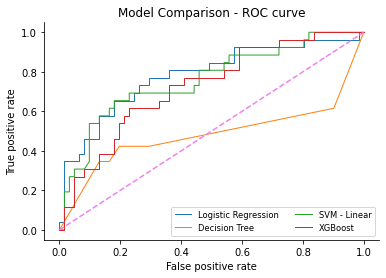

In [295]:
# Plot ROC Curves

plt.plot(fpr_lr, tpr_lr, lw=1, label='Logistic Regression')
plt.plot(fpr_dt, tpr_dt, lw=1, label='Decision Tree')
plt.plot(fpr_svm_model, tpr_svm_model, lw=1, label='SVM - Linear')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost')


plt.plot([0, 1], [0, 1], c='violet', ls='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model Comparison - ROC curve')
plt.legend(ncol=2, fontsize='small')
sns.despine()

<font color='red'>**Interpretation Wrap Up**</font>
- The idea is that the <font color='red'>**logistic regression is the best model to avoid false positive**</font> (the fact of predicting life when the outcome is actually death). In this specific case predicting that a patient will live when he actually will die is a dramatic mistakes when believing that a patient would die when he will actually live is ends up in a wonderfull good news. However, When the outcome is actually death (26 occurrence), the models predict live 11 times, he is therefore wrong almonst 1/2 of the times. 

- It is maybe not enougth to make it a model used in real life, let us try to check wether a Deep learning approach leads to substantial approach in the results.

# <font color='blue'>**Neural Network approach to predicting the heart failure rate.**</font>

In [604]:
import theano
print('ok theano')
import tensorflow
print('ok tensorflow')
import keras
print('libraries imported')

ok theano
ok tensorflow
libraries imported


## <font color='green'>**Model building, fitting and prediction.**</font>

In [605]:
from keras.models import Sequential ## Allow for initialization
from keras.layers import Dense ## Allow to select the layers
from keras.layers import Dropout

### - Initializarion

In [660]:
ann_classifier = Sequential()
ann_classifier.add(Dense(units=11, activation="relu", kernel_initializer='uniform', input_dim=11))

### - Building

In [661]:
ann_classifier.add(Dense(units=10, activation="relu", kernel_initializer='uniform'))
ann_classifier.add(Dropout(rate = 0.1))
ann_classifier.add(Dense(units=5, activation="relu", kernel_initializer='uniform'))
ann_classifier.add(Dropout(rate = 0.1))
ann_classifier.add(Dense(units=10, activation="relu", kernel_initializer='uniform'))
ann_classifier.add(Dropout(rate = 0.1))
ann_classifier.add(Dense(units=5, activation="relu", kernel_initializer='uniform'))
ann_classifier.add(Dropout(rate = 0.1))

### - Output layer

In [662]:
ann_classifier.add(Dense(units=1, activation="sigmoid", kernel_initializer='uniform'))

### - Compiling

In [663]:
ann_classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics =["accuracy"])

### - Model fitting

In [664]:
ann_classifier.fit(X_train_scaled, y_train, batch_size=10, epochs=100)

Epoch 1/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.6918
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.6981
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6864 - accuracy: 0.6981
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6835 - accuracy: 0.6981
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6804 - accuracy: 0.6981
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6775 - accuracy: 0.6981
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6742 - accuracy: 0.6981
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.6981
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6666 - accuracy: 0.6981
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6598 - accuracy: 0.6981
Epoch 11/

<font color='red'>**IMPORTANT: Keep in mind that here the outcome is stochastic, so we should re-run multiple times the model and assess its outer sample , TN, FP, FN, TP ratios, running multiple times the model we can see that it at least alway outperform the logistic regression. To have the most stable model, one should create an ensemble model, to optimize the bais/variance trade off...**</font>

### - Prediction

In [665]:
y_pred = ann_classifier.predict(X_test_scaled)

### - Shaping the outcome vector at a threshold of 50%
(If the predicted probability of being 1 is over 50%, the outcome is considered as 1, 0 otherwise)

In [666]:
y_pred_num = []
i=0
while i<len(y_pred):
    if y_pred[i]<0.5:
        y_pred_num.append(0)
    else:
        y_pred_num.append(1)
    i=i+1
y_pred_num = np.array(y_pred_num)

## <font color='green'>**Model evaluation**</font>

In [667]:
from sklearn.metrics import confusion_matrix
cfn = confusion_matrix(y_test, y_pred_num)
cfn

array([[51, 10],
       [ 7, 19]], dtype=int64)

<font color='red'>**Interpretation**</font>

Here we can see that (most accurate scenario registered) on 26 actual death we got wrong less 30% of the case, when the logistic regression did wrong almost 50% of the times.

In [670]:
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, ann_classifier.predict(X_test_scaled).ravel())
auc_ann = roc_auc_score(y_test, ann_classifier.predict(X_test_scaled))

# <font color='blue'>**Global Wrap Up**</font>

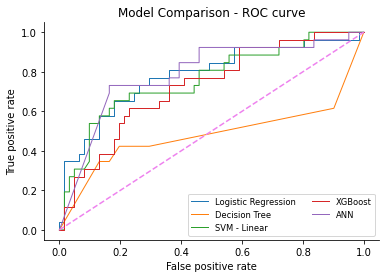

In [671]:
# Plot ROC Curves

plt.plot(fpr_lr, tpr_lr, lw=1, label='Logistic Regression')
plt.plot(fpr_dt, tpr_dt, lw=1, label='Decision Tree')
plt.plot(fpr_svm_model, tpr_svm_model, lw=1, label='SVM - Linear')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost')
plt.plot(fpr_ann, tpr_ann, lw=1, label='ANN')


plt.plot([0, 1], [0, 1], c='violet', ls='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model Comparison - ROC curve')
plt.legend(ncol=2, fontsize='small')
sns.despine()

<font color='black'>**As a conclusion we see that ANN outperform the other models at minimizing False negatives (predicting life when the actual outcome is death) with almost 80% of correct 'DEATH OUTCOME' prediction. In theory this should be the model to be selected. However, in a matter of deployability we will stand to the logistic function as it is computationnaly less intensive and more tractable in deployment.**</font>

### Saving models and weights

In [682]:
ann_classifier_json = ann_classifier.to_json()
with open("ann_classifier.json", "w") as json_file:
    json_file.write(ann_classifier_json)
# serialize weights to HDF5
ann_classifier.save_weights("ann_classifier.h5")
print("Saved model to disk")

Saved model to disk
